(MCP-lab)=
# Neuron MCP

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


## Definicja

Potrzebujemy podstawowego składnika ANN: sztucznego neuronu. Pierwszy model matematyczny pochodzi od Warrena McCullocha i Waltera Pittsa (MCP){cite}`McCulloch1943`, którzy zaproponowali go w 1942 roku, a więc na samym początku ery komputerów elektronicznych podczas II wojny światowej. Neuron MCP przedstawiony na {numref}`MCP1-fig` jest podstawowym składnikiem wszystkich ANN omawianych w tym kursie. Jest zbudowany na bardzo prostych ogólnych zasadach, inspirowanych przez neuron biologiczny:

- Sygnał wchodzi do jądra przez dendryty z innych neuronów.
- Połączenie synaptyczne dla każdego dendrytu może mieć inną (i regulowaną) siłę (wagę).
- W jądrze sygnał ważony ze wszystkich dendrytów jest sumowany i oznaczony jako $s$.
- Jeżeli sygnał $s$ jest silniejszy niż pewien zadany próg, to neuron odpala sygnał wzdłuż aksonu, w przeciwnym przypadku pozostaje pasywny.
- W najprostszej realizacji, siła odpalanego sygnału ma tylko dwa możliwe poziomy: włączony lub wyłączony, tj. 1 lub 0. Nie są potrzebne wartości pośrednie.
- Akson łączy się z dendrytami innych neuronów, przekazując im swój sygnał.

:::{figure-md} MCP1-fig
<img src="images/mcp-1a.png" width="320px">

Neuron MCP: $x_i$ oznaczają wejście, $w_i$  wagi, $s$ zsumowany sygnał, $b$ próg, a $f(s;b)$ reprezentuje funkcję aktywacji, dającą wyjście $y =f(s;b)$. Niebieski owal otacza cały neuron, jak np. w notacji {numref}`ffnn-fig`.
:::

Przekładając to na matematyczną receptę, przypisuje się komórkom wejściowym liczby $x_1, x_2 \dots, x_n$ (punkt danych wejściowych). Siła połączeń synaptycznych jest kontrolowana przez **wagi** $w_i$. Następnie łączny sygnał jest zdefiniowany jako suma ważona

$$s=\sum_{i=1}^n x_i w_i.$$

Sygnał staje się argumentem **funkcji aktywacji**, która w najprostszym przypadku przybiera postać funkcji schodkowej

$$f(s;b) = \left \{ \begin{array}{l} 1 {\rm ~dla~}s \ge b \\ 0 {\rm ~dla~}s < b \end{array} \right .$$

Gdy łączny sygnał $s$ jest większy niż próg $b$, jądro odpala. tj. sygnał idący wzdłuż aksonu wynosi 1. W przeciwnym przypadku wartość generowanego sygnału wynosi 0 (brak odpalenia). Właśnie tego potrzebujemy, aby naśladować biologiczny prototyp!

Istnieje wygodna konwencja, która jest często używana. Zamiast oddzielać próg od danych wejściowych, możemy traktować te liczby wrównoważny sposób. Warunek odpalenia może być trywialnie przekształcony jako

$$
s \ge b \to s-b \ge 0 \to \sum_{i=1}^n x_i w_i - b \ge 0 \to \sum_{i=1}^n x_i w_i +x_0 w_0 \ge 0
\to \sum_{i=0}^n x_i w_i \ge 0,
$$

gdzie $x_0=1$ i $w_0=-b$. Innymi słowy, możemy traktować próg jako wagę na krawędzi połączonej z dodatkową komórką z wejściem zawsze ustawionym na 1. Ta notacja jest pokazana na {numref}`MCP2-fig`. Teraz funkcja aktywacji wynosi po prostu

```{math}
:label: eq-f

f(s) = \left \{ \begin{array}{l} 1 {\rm ~for~} s \ge 0 \\ 0 {\rm ~for~} s < 0 \end{array} \right .,
```

ze wskaźnikiem sumowania w $s$ zaczynającym się $0$:

```{math}
:label: eq-f0
s=\sum_{i=0}^n x_i w_i = x_0 w_0+x_1 w_1 + \dots + x_n w_n.
```

:::{figure-md} MCP2-fig
<img src="images/mcp-2a.png" width="320px">

Alternatywna, bardziej jednorodna representacja neuronu MCP, z $x_0=1$ i $w_0=-b$.
:::

Wagi $w_0=-b,w_1,\dots,w_n$ są ogólnie określane jako **hiperparametry**. Określają one funkcjonalność neuronu MCP i mogą ulegać zmianie podczas procesu uczenia się (trenowania) sieci (patrz kolejne rozdziały). Natomiast są one ustalone podczas używania już wytrenowanej sieci na określonej próbce danych wejściowych.

```{important}
Istotną właściwością neuronów w ANN jest **nieliniowość** funkcji aktywacji. Bez tej cechy neuron MCP reprezentowałby po prostu iloczyn skalarny, a (wielowarstwowe) sieci feed-forward sprowadzałyby się do trywialnego mnożenia macierzy.
```

(mcp_P-lab)=
## Neuron MCP w Pythonie

Zaimplementujemy teraz model matematyczny neuronu MCP w Pythonie. Rzecz jasna, potrzebujemy tablic (wektorów), które są reprezentowane jako

In [3]:
x = [1,3,7]
w = [1,1,2.5]
x

[1, 3, 7]

i (**co ważne**) są indeksowane począwszy od 0, np.

In [4]:
x[0]

1

Zauważ, że wypisanie nazwy zmiennej na końcu komórki powoduje wydrukowanie jej zawartości.

Funkcje biblioteczne numpy mają przedrostek **np**, który jest aliasem podanym podczas importu. Funkcje te działają *dystrybucyjnie* na tablice, np.

In [5]:
np.sin(x)

array([0.84147098, 0.14112001, 0.6569866 ])

co jest bardzo wygodną własnością przy programowaniu. Mamy też do dyspozycji iloczyn skalarny $x \cdot w = \sum_i x_i w_i$, którego używamy do określenia sygnału $s$ wchodzącego do neuronu MCP:

In [6]:
np.dot(x,w)

21.5

Następnie musimy zdefiniować funkcję aktywacji neuronu, która w najprostszej postaci jest funkcją schodkową {eq}`eq-f`:

In [7]:
def step(s):       # step function (in the neural library)
     if s > 0:     # condition satisfied
        return 1
     else:         # otherwise
        return 0

Funkcja znajduje się też a pakiecie **neural**, zob. [dodatek](app-lab). Dla wzrokowców, wykres funkcji schodkowej jest następujący:

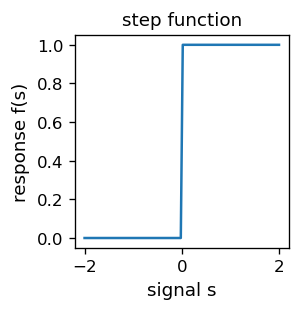

In [8]:
plt.figure(figsize=(2.3,2.3),dpi=120) # set the size and resolution of the figure

s = np.linspace(-2, 2, 100)   # array of 100+1 equally spaced points in [-2, 2]
fs = [step(z) for z in s]     # corresponding array of function values

plt.xlabel('signal s',fontsize=11)      # axes labels
plt.ylabel('response f(s)',fontsize=11)
plt.title('step function',fontsize=11)  # plot title

plt.plot(s, fs)
plt.show()

Ponieważ z definicji $x_0=1$, nie chcemy przekazywać tej wartości w argumentach funkcji modelujących neuron MCP. Będziemy zatem dodawać $x_0=1$ na początku danych wejściowych, jak w tym przykładzie:

In [9]:
x=[5,7]
np.insert(x,0,1) # insert 1 in x at position 0

array([1, 5, 7])

Jesteśmy teraz gotowi by zdefiniwać [neuron MCP](MCP1-fig):

In [10]:
def neuron(x,w,f=step): # (in the neural library)
    """                 
    MCP neuron

    x: array of inputs  [x1, x2,...,xn]
    w: array of weights [w0, w1, w2,...,wn]
    f: activation function, with step as default
    
    return: signal=weighted sum w0 + x1 w1 + x2 w2 +...+ xn wn = x.w
    """ 
    return f(np.dot(np.insert(x,0,1),w)) # insert x0=1 into x, output f(x.w)

Starannie umieszczamy stosowne komentarze w potrójnych cudzysłowach, aby w razie potrzeby móc uzyskać pomoc:

In [11]:
help(neuron)

Help on function neuron in module __main__:

neuron(x, w, f=<function step at 0x7fc98dc57550>)
    MCP neuron
    
    x: array of inputs  [x1, x2,...,xn]
    w: array of weights [w0, w1, w2,...,wn]
    f: activation function, with step as default
    
    return: signal=weighted sum w0 + x1 w1 + x2 w2 +...+ xn wn = x.w



Zauważ, że funkcja **f** jest argumentem **neuron**u. Argument ten jest domyślnie ustawiony jako **step**, więc nie musi być obecny na liście argumentów. Przykładowe użycie z $x_1=3$, $w_0=-b=-2$ i $w_1=1$ to

In [12]:
neuron([3],[-2,1])

1

Jak widzimy, w tym przypadku neuron odpalił, poniważ $s=1*(-2)+3*1>0$. 

Poniżej pokazujemy, jak neuron działa na daną wejściową $x_1$ wziętą z przedziału $[-2,2]$. Zmieniamy również wartość progu, aby zilustrować jego rolę: jeśli sygnał $x_1 w_1$ jest większy niż $b=-x_0$, neuron odpala.

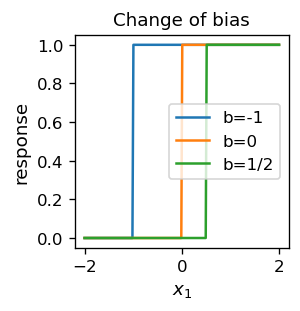

In [13]:
plt.figure(figsize=(2.3,2.3),dpi=120) 

s = np.linspace(-2, 2, 200)
fs1 = [neuron([x1],[1,1]) for x1 in s]      # more function on one plot
fs0 = [neuron([x1],[0,1]) for x1 in s]
fsm12 = [neuron([x1],[-1/2,1]) for x1 in s]

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('response',fontsize=11)

plt.title("Change of bias",fontsize=11)

plt.plot(s, fs1, label='b=-1')
plt.plot(s, fs0, label='b=0')
plt.plot(s, fsm12, label='b=1/2')
plt.legend()     # legend
plt.show()

Kiedy znak wagi $w_1$ jest ujemny, dostajemy **odwrotne** zachowanie: neuron odpala dla $x_1 |w_1| < w_0$: 

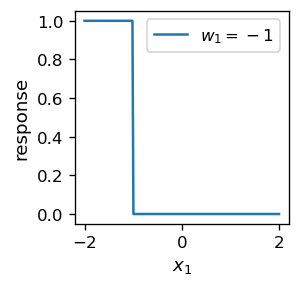

In [14]:
plt.figure(figsize=(2.3,2.3),dpi=120) 

s = np.linspace(-2, 2, 200)
gsm = [neuron([x1],[-1,-1]) for x1 in s]

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('response',fontsize=11)

plt.plot(s, gsm,label='$w_1=-1$')
plt.legend()
plt.show()

```{note} 
Począwszy od teraz, dla zwięzłości prezentacji, ukrywamy niektóre komórki kodu o powtarzającej się strukturze. Czytelnik może znaleźć pełny kod w oryginalnych notatnikach Jupytera.
```

Trzeba przyznać, że w ostatnim przykładzie odchodzi się od biologicznego wzorca, ponieważ ujemne wagi nie są możliwe do zrealizowania w biologicznym neuronie. Przyjeta swoboda wzbogaca jednak model matematyczny, który w oczywisty sposób można budować bez ograniczeń biologicznych.

(bool-sec)=
## Funkcje logiczne

Skonstruowawszy neuronu MCP w Pythonie możemy zadać pytanie: *Jaka jest najprostsze (ale wciąż nietrywialne) zastosowanie, w którym możemy go użyć?* Są to [funkcje logiczne](https://en .wikipedia.org/wiki/Boolean_function) lub sieci logiczne utworzone za pomocą sieci neuronów MCP. 

Funkcje logiczne z definicji mają argumenty i wartości zawierające się w zbiorze $\{ 0,1 \}$ lub {Prawda, Fałsz}.

Na rozgrzewkę zacznijmy od zgadywania, gdzie bierzemy neuron o wagach $w=[w_0,w_1,w_2]=[-1,0.6,0.6]$ (dlaczego nie). Oznaczmy też $x_1=p$, $x_2=q$, zgodnie z tradycyjną notacją zmiennych logicznych, gdzie $p,q \in \{0,1\}$.

In [15]:
print("p q n(p,q)") # print the header
print()             # print space

for p in [0,1]:       # loop over p
    for q in [0,1]:   # loop over q
        print(p,q,"",neuron([p,q],[-1,.6,.6])) # print all cases

p q n(p,q)

0 0  0
0 1  0
1 0  0
1 1  1


Natychmiast rozpoznajemy w powyższym wyniku tabelkę logiczną dla koniunkcji, $n(p,q)=p \land q$ lub logicznej operacji **AND**. Jest zupełnie jasne, dlaczego tak działa nasz neuron. Warunek odpalenia $n(p,q)=1$ wynosi $-1+p*0.6+q*0.6 \ge 0$ i jest spełniony wtedy i tylko wtedy, gdy $p=q=1$, co jest definicją koniunkcji logicznej. Oczywiście moglibyśmy użyć tutaj 0.7 zamiast 0.6, lub ogólnie $w_1$ i $w_2$ takie, że $w_1<1, w_2<1, w_1+w_2 \ge 1$. W terminologii elektronicznej obecny neuron możemy więc nazwać **bramką AND**.

Możemy w ten sposób zdefiniować funkcję

In [16]:
def neurAND(p,q): return neuron([p,q],[-1,.6,.6])

W podobny sposób możemy zdefiniować inne funkcje logiczne (bramki logiczne) dwóch zmiennych logicznych. W szczególności bramka NAND (negacja koniunkcji) i bramka OR (alternatywa) są realizowane poprzez następujące neurony MCP:

In [17]:
def neurNAND(p,q): return neuron([p,q],[1,-0.6,-0.6])
def neurOR(p,q):   return neuron([p,q],[-1,1.2,1.2])

Odpowiadają następującym tabelkom logicznym 

In [18]:
print("p q  NAND OR") # print the header
print()

for p in [0,1]: 
    for q in [0,1]: 
        print(p,q," ",neurNAND(p,q)," ",neurOR(p,q))

p q  NAND OR

0 0   1   0
0 1   1   1
1 0   1   1
1 1   0   1


### Problem z bramką XOR

Bramka XOR, lub **alternatywa wykluczjąca**, jest zdefiniowana za pomocą następującej tabelki logicznej:

$$
\begin{array}{ccc}
p & q & p \oplus q \\
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0
\end{array}
$$

Jest to jedna z możliwych funkcji binarnych dwóch argumentów (w sumie mamy 16 różnych funkcji tego rodzaju, dlaczego?). Moglibyśmy teraz próbować dobrać wagi w naszym neuronie, aby zachowywał się jak bramka XOR, ale jesteśmy skazani na porażkę. Oto jej powód:

Z pierwszego wiersza powyższej tabelki wynika, że dla wejścia 0, 0 neuron nie powinien odpalić. Stąd

$w_0 + 0* w_1 + 0*w_2 <0$ lub $-w_0>0$.

W przypadku wierszy 2 i 3 neuron musi odpalić, zatem

$w_0+w_2 \ge 0$ i $w_0+w_1 \ge 0$.

Dodając stronami te trzy uzyskane nierówności otrzymujemy $w_0+w_1+w_2 >0$. Jednak czwarty rząd tabelki daje
$w_0+w_1+w_2<0$ (brak odpalenia), więc uzyskujemy sprzeczność. Dlatego nie istnieje taki wybor $w_0, w_1, w_2$, aby neuron działał jak bramka XOR!

```{important}
Pojedynczy neuron MCP nie może działać jak bramka **XOR**.
```

### XOR ze złożenia bramek AND, NAND i OR

Można rozwiązać problem konstrukcji bramki XOR, składając trzy neurony MCP, np. 

In [19]:
def neurXOR(p,q): return neurAND(neurNAND(p,q),neurOR(p,q))

In [20]:
print("p q XOR") 
print()

for p in [0,1]: 
    for q in [0,1]: 
        print(p,q,"",neurXOR(p,q))

p q XOR

0 0  0
0 1  1
1 0  1
1 1  0


Powyższa konstrukcja odpowiada prostj sieci {numref}`xor-fig`.


:::{figure-md} xor-fig
<img src="images/xor.png" width="260px">

Bramka XOR złożona z neuronów NAND, OR i AND.
:::

Zauważmy, że po raz pierwszy mamy tu do czynienia z siecią posiadającą warstwę pośrednią, składającą się z neuronów NAND i OR. Ta warstwa jest nieodzowna do budowy bramki XOR.

### Bramka XOR złożona z bramek NAND

W ramach teorii sieci logicznych udowadnia się, że dowolna sieć (lub dowolna funkcja logiczna) może składać się wyłącznie z bramek NAND lub wyłącznie z bramek NOR. Mówi się, że bramki NAND (lub NOR) są **zupełne**. W szczególności bramka XOR może być skonstruowana jako

[ p NAND ( p NAND q ) ] NAND [ q NAND ( p NAND q ) ],

co możemy napisać w Pythonie jako

In [21]:
def nXOR(i,j): return neurNAND(neurNAND(i,neurNAND(i,j)),neurNAND(j,neurNAND(i,j)))

In [22]:
print("p q XOR") 
print()

for i in [0,1]: 
    for j in [0,1]: 
        print(i,j,"",nXOR(i,j)) 

p q XOR

0 0  0
0 1  1
1 0  1
1 1  0


```{note}
Dowodzi się, że sieci logiczne są zupełne w sensie [Churcha-Turinga](https://en.wikipedia.org/wiki/Church-Turing_thesis), tj. (jeśli są wystarczająco duże) mogą wykonać każde możliwe obliczenie. Ta własność jest bezpośrednio przenoszona na sieci ANN. Historycznie, było to podstawowe odkrycie przełomowego artykułu MCP {cite}`McCulloch1943`.
```

```{admonition} Wniosek
:class: Important

Dostatecznie duże ANN mogą wykonac każde obliczenie!
```

## Ćwiczenia

```{admonition} $~$
:class: warning


Skonstruuj (wszystko w Pythonie)

- bramkę realizująca koniunkcję kilku zmiennych logicznych;
- bramki NOT, NOR;
- bramki OR, AND i NOT poprzez [złożenie bramek NAND](https://en.wikipedia.org/wiki/NAND_logic);
- [pół sumator i pełny sumator](https://en.wikipedia.org/wiki/Adder_(electronics)),

jako sieci neuronów MCP.
```